#Bitcoin price predictor use ML

## Import the necessary libraries

In [1]:
!pip install arch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore")
import arch


##Fetching data from the server , organize it and clean it

In [3]:
url = 'https://api.binance.com/api/v3/klines'
r = requests.get(url,params={'symbol':'BTCUSDT','interval': '1m','limit':2000})
r

<Response [200]>

### Frame Collumn Formatting

In [4]:
collumns = """

1499040000000,      // Open time
    "0.01634790",       // Open
    "0.80000000",       // High
    "0.01575800",       // Low
    "0.01577100",       // Close
    "148976.11427815",  // Volume
    1499644799999,      // Close time
    "2434.19055334",    // Quote asset volume
    308,                // Number of trades
    "1756.87402397",    // Taker buy base asset volume
    "28.46694368",      // Taker buy quote asset volume
    "17928899.62484339" // Ignore.

""".split("//")[1:-1]


my_col_names = [sub_str.split('\n')[0].lower().strip().replace(' ','_') for sub_str in collumns]
# my_col_names.insert(0, 'timestamp')
my_col_names.append('ignore')
my_col_names

['open_time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'close_time',
 'quote_asset_volume',
 'number_of_trades',
 'taker_buy_base_asset_volume',
 'taker_buy_quote_asset_volume',
 'ignore']

In [5]:
df = pd.DataFrame(r.json(),columns = my_col_names)
df.index = pd.to_datetime(df.open_time*1000000)
#df.index = pd.DatetimeIndex(df.open_time*1000000)
df.index.name = 'Date'
df = df.drop(columns=['open_time','close_time','ignore'])
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
Date,,,,,,,,,
2022-01-05 10:38:00,46745.49000000,46748.62000000,46711.53000000,46731.91000000,18.89581000,883128.89940300,705,11.14003000,520672.15786530
2022-01-05 10:39:00,46731.92000000,46742.00000000,46727.02000000,46741.99000000,11.04390000,516103.87204010,447,6.77630000,316671.31471740
2022-01-05 10:40:00,46741.99000000,46771.81000000,46741.99000000,46764.06000000,13.43872000,628330.67476550,635,7.94018000,371245.44859570
2022-01-05 10:41:00,46764.07000000,46795.83000000,46764.06000000,46770.16000000,14.79116000,691919.14080280,714,8.66768000,405455.12630750
2022-01-05 10:42:00,46770.17000000,46786.59000000,46755.69000000,46768.62000000,10.80785000,505543.77664990,460,4.77526000,223360.96941870
...,...,...,...,...,...,...,...,...,...
2022-01-06 03:13:00,43180.92000000,43236.13000000,43166.26000000,43219.73000000,66.22635000,2860592.00146000,998,29.63234000,1279750.43679190
2022-01-06 03:14:00,43219.72000000,43244.71000000,43204.59000000,43239.05000000,20.20555000,873474.31276850,677,7.83588000,338707.71325180
2022-01-06 03:15:00,43239.05000000,43260.33000000,43185.07000000,43193.55000000,25.28753000,1092766.34508210,725,8.50719000,367602.81235540


In [6]:
r = requests.get(url,params={'symbol':'BTCUSDT','interval': '1m','limit':2000,'endTime':(1641348720-1)*2000})
pd.DatetimeIndex(pd.DataFrame(r.json(),columns = my_col_names).open_time*1000000)

DatetimeIndex(['2022-01-05 10:38:00', '2022-01-05 10:39:00',
               '2022-01-05 10:40:00', '2022-01-05 10:41:00',
               '2022-01-05 10:42:00', '2022-01-05 10:43:00',
               '2022-01-05 10:44:00', '2022-01-05 10:45:00',
               '2022-01-05 10:46:00', '2022-01-05 10:47:00',
               ...
               '2022-01-06 03:08:00', '2022-01-06 03:09:00',
               '2022-01-06 03:10:00', '2022-01-06 03:11:00',
               '2022-01-06 03:12:00', '2022-01-06 03:13:00',
               '2022-01-06 03:14:00', '2022-01-06 03:15:00',
               '2022-01-06 03:16:00', '2022-01-06 03:17:00'],
              dtype='datetime64[ns]', name='open_time', length=1000, freq=None)

### Creating a new column for better representing day-wise values

In [7]:
df["low"] = pd.to_numeric(df["low"])
df["high"] = pd.to_numeric(df["high"])
df['Mean'] = (df['low'] + df['high'])/2
df=df.dropna()
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,Mean
Date,,,,,,,,,,
2022-01-05 10:38:00,46745.49000000,46748.62,46711.53,46731.91000000,18.89581000,883128.89940300,705,11.14003000,520672.15786530,46730.075
2022-01-05 10:39:00,46731.92000000,46742.00,46727.02,46741.99000000,11.04390000,516103.87204010,447,6.77630000,316671.31471740,46734.510
2022-01-05 10:40:00,46741.99000000,46771.81,46741.99,46764.06000000,13.43872000,628330.67476550,635,7.94018000,371245.44859570,46756.900
2022-01-05 10:41:00,46764.07000000,46795.83,46764.06,46770.16000000,14.79116000,691919.14080280,714,8.66768000,405455.12630750,46779.945
2022-01-05 10:42:00,46770.17000000,46786.59,46755.69,46768.62000000,10.80785000,505543.77664990,460,4.77526000,223360.96941870,46771.140
...,...,...,...,...,...,...,...,...,...,...
2022-01-06 03:13:00,43180.92000000,43236.13,43166.26,43219.73000000,66.22635000,2860592.00146000,998,29.63234000,1279750.43679190,43201.195
2022-01-06 03:14:00,43219.72000000,43244.71,43204.59,43239.05000000,20.20555000,873474.31276850,677,7.83588000,338707.71325180,43224.650
2022-01-06 03:15:00,43239.05000000,43260.33,43185.07,43193.55000000,25.28753000,1092766.34508210,725,8.50719000,367602.81235540,43222.700


In [8]:
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift()
dataset_for_prediction=dataset_for_prediction.dropna()
dataset_for_prediction

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,Mean,Actual
Date,,,,,,,,,,,
2022-01-05 10:39:00,46731.92000000,46742.00,46727.02,46741.99000000,11.04390000,516103.87204010,447,6.77630000,316671.31471740,46734.510,46730.075
2022-01-05 10:40:00,46741.99000000,46771.81,46741.99,46764.06000000,13.43872000,628330.67476550,635,7.94018000,371245.44859570,46756.900,46734.510
2022-01-05 10:41:00,46764.07000000,46795.83,46764.06,46770.16000000,14.79116000,691919.14080280,714,8.66768000,405455.12630750,46779.945,46756.900
2022-01-05 10:42:00,46770.17000000,46786.59,46755.69,46768.62000000,10.80785000,505543.77664990,460,4.77526000,223360.96941870,46771.140,46779.945
2022-01-05 10:43:00,46768.61000000,46770.00,46741.71,46741.71000000,13.92236000,650942.52587600,334,7.37993000,345055.42542890,46755.855,46771.140
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06 03:13:00,43180.92000000,43236.13,43166.26,43219.73000000,66.22635000,2860592.00146000,998,29.63234000,1279750.43679190,43201.195,43183.900
2022-01-06 03:14:00,43219.72000000,43244.71,43204.59,43239.05000000,20.20555000,873474.31276850,677,7.83588000,338707.71325180,43224.650,43201.195
2022-01-06 03:15:00,43239.05000000,43260.33,43185.07,43193.55000000,25.28753000,1092766.34508210,725,8.50719000,367602.81235540,43222.700,43224.650


##LinearRegression MODEL

In [9]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
N=2411

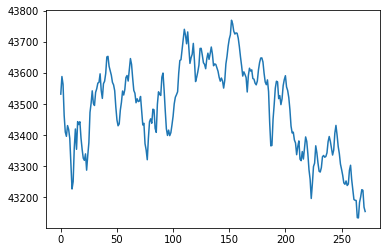

In [10]:
X=[]
for i in range(2411):
    X.append([i])
X=np.array(X)
Xtrain=X[:N]
Xtest=X[-272:]
Y=df["Mean"]
Y=np.array(Y,dtype='float32')
ytrain=Y[:N]
ytest=Y[-272:]
arr=ytest
plt.plot(arr,label='actual')


## GARCH-SARIMAX model

In [11]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['low', 'high', 'open', 'close', 'volume', 'Mean']])
scaled_input = pd.DataFrame(scaled_input, index=dataset_for_prediction.index)
X= scaled_input
X.rename(columns={0:'low', 1:'high', 2:'open', 3:'close', 4:'volume', 5:'Mean'}, inplace=True)
print(X.head())

                          low      high      open     close    volume      Mean
Date                                                                           
2022-01-05 10:39:00  0.978819  0.969683  0.978284  0.980638  0.004907  0.976616
2022-01-05 10:40:00  0.982285  0.976785  0.980640  0.985800  0.006463  0.981887
2022-01-05 10:41:00  0.987396  0.982508  0.985805  0.987227  0.007343  0.987312
2022-01-05 10:42:00  0.985458  0.980306  0.987232  0.986867  0.004753  0.985240
2022-01-05 10:43:00  0.982221  0.976354  0.986867  0.980572  0.006778  0.981641


In [12]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output, index=dataset_for_prediction.index)
y=scaler_output
y.rename(columns={0:'BTC Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
print(y.head())

                     BTC Price next day
Date                                   
2022-01-05 10:39:00            0.975572
2022-01-05 10:40:00            0.976616
2022-01-05 10:41:00            0.981887
2022-01-05 10:42:00            0.987312
2022-01-05 10:43:00            0.985240


In [13]:
train_size=int(len(df) *0.9)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [15]:
predic_garch =[]
for i in range(test_size):
  model= SARIMAX(pd.concat([train_y,test_y.iloc[:i+1]]),
  exog=pd.concat([train_X,test_X.iloc[:i+1]]),
  order=(0,1,1),
  seasonal_order =(0, 0, 1, 12),
  enforce_invertibility=False, enforce_stationarity=False)
  results= model.fit()
  garch = arch.arch_model(results.resid, p=1, q=1,vol='GARCH')
  garch_model = garch.fit(update_freq=1)
  garch_forecast = garch_model.forecast(start = train_size-1,horizon=1,method='simulation')
  predicted_et = garch_forecast.mean['h.1'].iloc[-1]
  predic_garch.append(predicted_et)
  print(predicted_et)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3136.0913223536686
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3136.6977275305608
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3135.390923920272
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3096.8138832412405
Iteration:      5,   Func. Count:     70,   Neg. LLF: 725.3249677897252
Iteration:      6,   Func. Count:     81,   Neg. LLF: -601.0182714327669
Iteration:      7,   Func. Count:     88,   Neg. LLF: -895.293766850878
Iteration:      8,   Func. Count:     94,   Neg. LLF: -1548.2678674581027
Iteration:      9,   Func. Count:    101,   Neg. LLF: -1641.3165540675552
Iteration:     10,   Func. Count:    116,   Neg. LLF: -1932.9285666377255
Iteration:     11,   Func. Count:    128,   Neg. LLF: -1933.4826567900675
Iteration:     12,   Func. Count:    141,   Neg. LLF: -1934.0409544831448
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1934.0409613588245
       

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3140.4833287490874
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3141.087569624063
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3138.879399271635
Iteration:      4,   Func. Count:     54,   Neg. LLF: -2640.8196079431295
Iteration:      5,   Func. Count:     70,   Neg. LLF: 1178.7673946856648
Iteration:      6,   Func. Count:     80,   Neg. LLF: 20.3392837650282
Iteration:      7,   Func. Count:     87,   Neg. LLF: -723.93124504209
Iteration:      8,   Func. Count:     94,   Neg. LLF: -1929.8634152131553
Iteration:      9,   Func. Count:    107,   Neg. LLF: -1931.1140373050978
Iteration:     10,   Func. Count:    118,   Neg. LLF: -1931.1164536133228
Iteration:     11,   Func. Count:    125,   Neg. LLF: -1976.373999025915
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1976.374007303315
            Iterations: 15
            Function evaluations: 125
            Gradient 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3144.8237481453325
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3145.4210131434866
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3145.495021625346
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3145.4775648335026
Iteration:      5,   Func. Count:     69,   Neg. LLF: -3145.4900546487015
Iteration:      6,   Func. Count:     85,   Neg. LLF: -3145.491567996799
Iteration:      7,   Func. Count:     99,   Neg. LLF: -3145.4950460541813
Iteration:      8,   Func. Count:    115,   Neg. LLF: -3145.494237564766
Iteration:      9,   Func. Count:    129,   Neg. LLF: -3145.4943420684885
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3145.494350914686
            Iterations: 13
            Function evaluations: 129
            Gradient evaluations: 9
-0.00021445149799583548


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3148.8977391824383
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3149.4786636025237
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3108.1511512300926
Iteration:      4,   Func. Count:     54,   Neg. LLF: 757.3814355281335
Iteration:      5,   Func. Count:     65,   Neg. LLF: 57.175998091944834
Iteration:      6,   Func. Count:     72,   Neg. LLF: -1982.2826702764685
Iteration:      7,   Func. Count:     85,   Neg. LLF: -1983.5646886823233
Iteration:      8,   Func. Count:     96,   Neg. LLF: -1983.572008674701
Iteration:      9,   Func. Count:    105,   Neg. LLF: -1983.868446352023
Iteration:     10,   Func. Count:    118,   Neg. LLF: -1984.293254778953
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1984.2932656176195
            Iterations: 14
            Function evaluations: 118
            Gradient evaluations: 10
-0.0002902300317150484


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3152.949159863113
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3153.534919427886
Iteration:      3,   Func. Count:     38,   Neg. LLF: -2987.3831267861
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1330.09246243704
Iteration:      5,   Func. Count:     64,   Neg. LLF: 420.69457532794667
Iteration:      6,   Func. Count:     71,   Neg. LLF: -1937.436526649607
Iteration:      7,   Func. Count:     80,   Neg. LLF: -2049.145275676095
Iteration:      8,   Func. Count:     92,   Neg. LLF: -2049.1642534235043
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2049.164264916105
            Iterations: 12
            Function evaluations: 101
            Gradient evaluations: 8
-0.0003048296331581223


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3157.251606357201
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3157.8532243860022
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3090.015687878843
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1015.2661057145485
Iteration:      5,   Func. Count:     65,   Neg. LLF: -1563.4003845601953
Iteration:      6,   Func. Count:     74,   Neg. LLF: -2392.393320041995
Iteration:      7,   Func. Count:     90,   Neg. LLF: -1379.6103892631156
Iteration:      8,   Func. Count:    106,   Neg. LLF: -808.2951409122691
Iteration:      9,   Func. Count:    112,   Neg. LLF: -903.9411658852384
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -903.941083415802
            Iterations: 13
            Function evaluations: 112
            Gradient evaluations: 9
-0.036629311913503125


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3161.4812039322064
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3162.085753062521
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3148.490531548635
Iteration:      4,   Func. Count:     54,   Neg. LLF: -9.605898470509613
Iteration:      5,   Func. Count:     67,   Neg. LLF: -1084.0395254947412
Iteration:      6,   Func. Count:     74,   Neg. LLF: -2103.571785538871
Iteration:      7,   Func. Count:     89,   Neg. LLF: -3087.3551286198663
Iteration:      8,   Func. Count:    105,   Neg. LLF: 1288.895144210695
Iteration:      9,   Func. Count:    115,   Neg. LLF: 549.4661069619312
Iteration:     10,   Func. Count:    122,   Neg. LLF: -914.0422201736383
Iteration:     11,   Func. Count:    133,   Neg. LLF: -1841.9343621402031
Iteration:     12,   Func. Count:    146,   Neg. LLF: -1842.2088733098744
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1842.208894537669
           

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3165.6589151545386
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3166.2757898804707
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3166.2985592935543
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3166.2894228245314
Iteration:      5,   Func. Count:     68,   Neg. LLF: -3166.298568573605
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3166.2985775066263
            Iterations: 9
            Function evaluations: 68
            Gradient evaluations: 5
-0.00019889216353389453


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3170.058463057062
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3170.673378921625
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3170.6850571464183
Iteration:      4,   Func. Count:     47,   Neg. LLF: -3170.6904767613914
Iteration:      5,   Func. Count:     61,   Neg. LLF: -3170.695897632795
Iteration:      6,   Func. Count:     72,   Neg. LLF: -3170.699937199228
Iteration:      7,   Func. Count:     88,   Neg. LLF: -3170.667804985306
Iteration:      8,   Func. Count:    104,   Neg. LLF: -3170.7039549359006
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3170.7039638825763
            Iterations: 12
            Function evaluations: 104
            Gradient evaluations: 8
-0.00019384254163842758


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3173.9842083629655
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3174.597478439203
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3174.4180800385043
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3174.6055105125297
Iteration:      5,   Func. Count:     67,   Neg. LLF: -3174.6153906413415
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3174.615399622974
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 5
-0.00020088031552322364


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3177.8978115481473
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3178.509043349365
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3178.5400596345053
Iteration:      4,   Func. Count:     49,   Neg. LLF: -3178.5400903501163
Iteration:      5,   Func. Count:     63,   Neg. LLF: -3178.5401709007865
Iteration:      6,   Func. Count:     79,   Neg. LLF: -3178.5390457387493
Iteration:      7,   Func. Count:     95,   Neg. LLF: -3178.540138872914
Iteration:      8,   Func. Count:    108,   Neg. LLF: -3178.5401670975534
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3178.540176041162
            Iterations: 12
            Function evaluations: 108
            Gradient evaluations: 8
-0.00020966684474186596


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3181.994395162613
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3182.5918545929867
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3181.7410890078836
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3180.814265158598
Iteration:      5,   Func. Count:     70,   Neg. LLF: -761.7182113897636
Iteration:      6,   Func. Count:     85,   Neg. LLF: -1824.6124024358114
Iteration:      7,   Func. Count:     92,   Neg. LLF: -2231.3531272889213
Iteration:      8,   Func. Count:    105,   Neg. LLF: -2279.516604010437
Iteration:      9,   Func. Count:    118,   Neg. LLF: -2279.705310666354
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2279.705322563478
            Iterations: 13
            Function evaluations: 118
            Gradient evaluations: 9
-0.0002795649534631282


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3186.4210907004526
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3187.017153820215
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3097.716584825785
Iteration:      4,   Func. Count:     54,   Neg. LLF: 3432.6876306952445
Iteration:      5,   Func. Count:     63,   Neg. LLF: -11.290738464005706
Iteration:      6,   Func. Count:     71,   Neg. LLF: -906.1916586102643
Iteration:      7,   Func. Count:     78,   Neg. LLF: -2006.013532361254
Iteration:      8,   Func. Count:     89,   Neg. LLF: -2074.3377379605977
Iteration:      9,   Func. Count:    100,   Neg. LLF: -2075.9122835044727
Iteration:     10,   Func. Count:    110,   Neg. LLF: -2075.9619324529403
Iteration:     11,   Func. Count:    117,   Neg. LLF: -2163.494636757627
Iteration:     12,   Func. Count:    133,   Neg. LLF: -2177.7666374629325
Iteration:     13,   Func. Count:    145,   Neg. LLF: -2177.771229078033
Iteration:     14,   Func. Count:    158,   N

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3190.643422191457
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3191.2369605787917
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3189.2334932002245
Iteration:      4,   Func. Count:     54,   Neg. LLF: -2840.9929283576294
Iteration:      5,   Func. Count:     70,   Neg. LLF: 1664.6816009051395
Iteration:      6,   Func. Count:     79,   Neg. LLF: 1311.2997324880903
Iteration:      7,   Func. Count:     85,   Neg. LLF: 611.974540006009
Iteration:      8,   Func. Count:     92,   Neg. LLF: -1933.5470536313296
Iteration:      9,   Func. Count:    102,   Neg. LLF: -1944.704686628787
Iteration:     10,   Func. Count:    111,   Neg. LLF: -1944.7547683019575
Iteration:     11,   Func. Count:    118,   Neg. LLF: -1964.8570812072244
Iteration:     12,   Func. Count:    128,   Neg. LLF: -1990.3394969468893
Iteration:     13,   Func. Count:    140,   Neg. LLF: -1990.4562503493976
Iteration:     14,   Func. Count:    152,   N

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3195.356033183337
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3195.9516230490663
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3195.981885409027
Iteration:      4,   Func. Count:     50,   Neg. LLF: -3195.997656972423
Iteration:      5,   Func. Count:     63,   Neg. LLF: -3195.9976974170804
Iteration:      6,   Func. Count:     76,   Neg. LLF: -3195.997725898317
Iteration:      7,   Func. Count:     92,   Neg. LLF: -3195.997727426486
Iteration:      8,   Func. Count:    108,   Neg. LLF: -3195.986218454281
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3195.986227345351
            Iterations: 12
            Function evaluations: 108
            Gradient evaluations: 8
-0.00017905494173968244


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3188.5646917979643
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3189.0973128776936
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3189.0584077165076
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3189.097394804651
Iteration:      5,   Func. Count:     70,   Neg. LLF: -3189.0973000501826
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3189.097308510967
            Iterations: 9
            Function evaluations: 70
            Gradient evaluations: 5
-0.00022221599809234277


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3194.8995269075463
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3195.375195929405
Iteration:      3,   Func. Count:     35,   Neg. LLF: -3195.375232975246
Iteration:      4,   Func. Count:     51,   Neg. LLF: -3195.372273480667
Iteration:      5,   Func. Count:     65,   Neg. LLF: -3195.374458354787
Iteration:      6,   Func. Count:     81,   Neg. LLF: -3195.3740421234556
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3195.3740549386903
            Iterations: 9
            Function evaluations: 91
            Gradient evaluations: 6
-0.00020393788624345808


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3195.615521103213
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3196.177823126532
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3196.0563404744557
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3196.1781742728335
Iteration:      5,   Func. Count:     69,   Neg. LLF: -3196.1704676476643
Iteration:      6,   Func. Count:     85,   Neg. LLF: -3196.178168034054
Iteration:      7,   Func. Count:    101,   Neg. LLF: -3196.1760729559996
Iteration:      8,   Func. Count:    115,   Neg. LLF: -3196.1773403758707
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3196.1773487724768
            Iterations: 12
            Function evaluations: 115
            Gradient evaluations: 8
-0.0002198861478001397


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3198.8472475733793
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3199.4462606944644
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3199.3416914818918
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3199.4462246673856
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3199.446233016646
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 4
-0.00021168364138352246


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3202.4722629210905
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3203.083178850976
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3202.7025183584024
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3108.761097763283
Iteration:      5,   Func. Count:     70,   Neg. LLF: 1131.0417172753773
Iteration:      6,   Func. Count:     80,   Neg. LLF: 414.4801555891113
Iteration:      7,   Func. Count:     87,   Neg. LLF: -1949.7212532670403
Iteration:      8,   Func. Count:     96,   Neg. LLF: -2022.4835242992517
Iteration:      9,   Func. Count:    107,   Neg. LLF: -2022.5975710336784
Iteration:     10,   Func. Count:    119,   Neg. LLF: -2022.613414834535
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2022.6134260203485
            Iterations: 14
            Function evaluations: 119
            Gradient evaluations: 10
-0.00029249662424901397


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3206.1463988807272
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3206.768133362331
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3206.772725141681
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3206.7729131938722
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3206.7729215642203
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 4
-0.00021339326511539105


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3210.186458900421
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3210.8130729817935
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3210.824815590622
Iteration:      4,   Func. Count:     47,   Neg. LLF: -3210.830554886784
Iteration:      5,   Func. Count:     61,   Neg. LLF: -3210.8362956993933
Iteration:      6,   Func. Count:     77,   Neg. LLF: -3210.7764204313175
Iteration:      7,   Func. Count:     93,   Neg. LLF: -3208.5145322753033
Iteration:      8,   Func. Count:    109,   Neg. LLF: 376.4994299199808
Iteration:      9,   Func. Count:    115,   Neg. LLF: 332.3753548038535
Iteration:     10,   Func. Count:    121,   Neg. LLF: 319.33663475190787
Iteration:     11,   Func. Count:    127,   Neg. LLF: 308.391139677659
Iteration:     12,   Func. Count:    133,   Neg. LLF: 176.06445599307142
Iteration:     13,   Func. Count:    139,   Neg. LLF: -913.373668302153
Iteration:     14,   Func. Count:    149,   Neg. LLF

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3213.2500755431183
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3213.869749679813
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3213.888265779414
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3213.8870610238005
Iteration:      5,   Func. Count:     66,   Neg. LLF: -3213.8875202183253
Iteration:      6,   Func. Count:     80,   Neg. LLF: -3213.8877194506995
Iteration:      7,   Func. Count:     96,   Neg. LLF: -3213.8873029587435
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3213.8873114093603
            Iterations: 11
            Function evaluations: 96
            Gradient evaluations: 7
-0.0002105905342599806


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3217.1163293816
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3217.7316076465395
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3217.6563272587814
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3217.73669819981
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3217.736706663859
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 4
-0.00020441469809685518


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3220.967989340602
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3221.5780466797987
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3221.5765217922935
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3221.5806447587665
Iteration:      5,   Func. Count:     70,   Neg. LLF: -3221.5462111590514
Iteration:      6,   Func. Count:     84,   Neg. LLF: -3221.5803306969065
Iteration:      7,   Func. Count:    100,   Neg. LLF: -3221.5777689120105
Iteration:      8,   Func. Count:    114,   Neg. LLF: -3221.579817207009
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3221.5798257147353
            Iterations: 12
            Function evaluations: 114
            Gradient evaluations: 8
-0.00021009064488051028


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3224.976031670499
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3225.583209582244
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3225.5848536990716
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3225.576883395689
Iteration:      5,   Func. Count:     68,   Neg. LLF: -3225.5839595141024
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3225.5839680583613
            Iterations: 9
            Function evaluations: 68
            Gradient evaluations: 5
-0.00020795288085582596


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3229.1253204152245
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3229.734053077439
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3229.725694575298
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3229.6795737277303
Iteration:      5,   Func. Count:     69,   Neg. LLF: -3229.7356815674875
Iteration:      6,   Func. Count:     85,   Neg. LLF: -3229.7331497908717
Iteration:      7,   Func. Count:     99,   Neg. LLF: -3229.734850636155
Iteration:      8,   Func. Count:    115,   Neg. LLF: -3229.734789557194
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3229.7347981217586
            Iterations: 12
            Function evaluations: 115
            Gradient evaluations: 8
-0.00021243085518048418


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3232.7540281877373
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3233.363562730251
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3233.1786632321223
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3233.363803083248
Iteration:      5,   Func. Count:     67,   Neg. LLF: -3233.365466661141
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3233.3654752587636
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 5
-0.00020651765570712749


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3236.7056368331005
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3237.316671690186
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3237.0894069767273
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3237.2673099997437
Iteration:      5,   Func. Count:     69,   Neg. LLF: -3237.3034452339352
Iteration:      6,   Func. Count:     85,   Neg. LLF: -3237.2617818494177
Iteration:      7,   Func. Count:    100,   Neg. LLF: -3237.316032718638
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3237.316041351567
            Iterations: 11
            Function evaluations: 100
            Gradient evaluations: 7
-0.0002009416872741573


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3243.717883642873
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3244.2626081082276
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3244.2235116215406
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3244.2611823955226
Iteration:      5,   Func. Count:     68,   Neg. LLF: -3244.2618283330708
Iteration:      6,   Func. Count:     77,   Neg. LLF: -3244.994480948916
Iteration:      7,   Func. Count:     93,   Neg. LLF: -3245.475998201159
Iteration:      8,   Func. Count:    109,   Neg. LLF: -3242.4552402116237
Iteration:      9,   Func. Count:    125,   Neg. LLF: -1968.3777037972009
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1968.3777001840085
            Iterations: 13
            Function evaluations: 125
            Gradient evaluations: 9
0.026726250425529816


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3250.802695358761
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3251.2686270049185
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3251.2686068463063
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3251.268656765882
Iteration:      5,   Func. Count:     68,   Neg. LLF: -3251.258497414979
Iteration:      6,   Func. Count:     82,   Neg. LLF: -3251.268679509347
Iteration:      7,   Func. Count:     98,   Neg. LLF: -3251.263664457141
Iteration:      8,   Func. Count:    112,   Neg. LLF: -3251.2686988721966
Iteration:      9,   Func. Count:    128,   Neg. LLF: -3251.207742258569
Iteration:     10,   Func. Count:    143,   Neg. LLF: -3251.2679496567844
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3251.267957403158
            Iterations: 14
            Function evaluations: 143
            Gradient evaluations: 10
-0.0001697076980964583


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3249.1874064939516
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3249.7828583603427
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3249.4218041296053
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3243.496184013121
Iteration:      5,   Func. Count:     70,   Neg. LLF: -823.3326265090668
Iteration:      6,   Func. Count:     85,   Neg. LLF: -1492.3071816436332
Iteration:      7,   Func. Count:     91,   Neg. LLF: -1923.6455245836764
Iteration:      8,   Func. Count:    105,   Neg. LLF: -1966.1729923982973
Iteration:      9,   Func. Count:    118,   Neg. LLF: -1967.436574531634
Iteration:     10,   Func. Count:    127,   Neg. LLF: -1968.3335929638106
Iteration:     11,   Func. Count:    135,   Neg. LLF: -1969.680403365144
Iteration:     12,   Func. Count:    143,   Neg. LLF: -1972.8007025243871
Iteration:     13,   Func. Count:    151,   Neg. LLF: -1979.3356531104591
Iteration:     14,   Func. Count:    166, 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3253.404337704061
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3254.000513538281
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3254.001604793276
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3254.0016135073433
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 3
-0.00020350158298568035


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3256.857643714237
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3257.445516790057
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3256.521331026578
Iteration:      4,   Func. Count:     54,   Neg. LLF: -315.47540830096233
Iteration:      5,   Func. Count:     63,   Neg. LLF: -316.13345591581106
Iteration:      6,   Func. Count:     69,   Neg. LLF: -359.1322796768703
Iteration:      7,   Func. Count:     75,   Neg. LLF: -662.4557875505675
Iteration:      8,   Func. Count:     82,   Neg. LLF: -2051.883881171335
Iteration:      9,   Func. Count:     91,   Neg. LLF: -2183.839579583654
Iteration:     10,   Func. Count:    106,   Neg. LLF: -2188.767026088046
Iteration:     11,   Func. Count:    118,   Neg. LLF: -2188.768959044367
Iteration:     12,   Func. Count:    130,   Neg. LLF: -2188.771432182809
Iteration:     13,   Func. Count:    138,   Neg. LLF: -2190.6584203821653
Iteration:     14,   Func. Count:    153,   Neg.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3260.0640450975816
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3260.6619756521204
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3260.2541357150776
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3260.6630660876667
Iteration:      5,   Func. Count:     70,   Neg. LLF: -3260.08830805654
Iteration:      6,   Func. Count:     86,   Neg. LLF: -3260.6616172011363
Iteration:      7,   Func. Count:    102,   Neg. LLF: -3260.2536402019296
Iteration:      8,   Func. Count:    118,   Neg. LLF: -3260.662154052493
Iteration:      9,   Func. Count:    134,   Neg. LLF: -3259.7167257588985
Iteration:     10,   Func. Count:    150,   Neg. LLF: -3258.265231531099
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3258.265240022496
            Iterations: 14
            Function evaluations: 150
            Gradient evaluations: 10
-0.0006688801179681451


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3264.7798857230587
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3265.373025015698
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3265.3739705236007
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3265.3693218526496
Iteration:      5,   Func. Count:     66,   Neg. LLF: -3265.3731275151413
Iteration:      6,   Func. Count:     82,   Neg. LLF: -3265.3731694961025
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3265.3731780141766
            Iterations: 10
            Function evaluations: 82
            Gradient evaluations: 6
-0.00021518921541929895


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3268.3564472315193
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3268.9597254533264
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3268.9601648086273
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3268.932475796098
Iteration:      5,   Func. Count:     66,   Neg. LLF: -3268.9603571045354
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3268.9603603324704
            Iterations: 7
            Function evaluations: 77
            Gradient evaluations: 5
-0.00021027531578749528


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3273.0034002890707
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3273.590248299579
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3273.42871458204
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3273.590145224909
Iteration:      5,   Func. Count:     66,   Neg. LLF: -3273.5902100546473
Iteration:      6,   Func. Count:     82,   Neg. LLF: -3273.5471165103845
Iteration:      7,   Func. Count:     96,   Neg. LLF: -3273.584168081935
Iteration:      8,   Func. Count:    112,   Neg. LLF: -3273.537274082454
Iteration:      9,   Func. Count:    127,   Neg. LLF: -3273.588225604625
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3273.588234050652
            Iterations: 13
            Function evaluations: 127
            Gradient evaluations: 9
-0.0002145435510186385


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3275.173689663474
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3275.7787204371452
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3275.7762504616194
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3275.783755140206
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3275.7837637865255
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 4
-0.00022644112953792636


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3279.0826426922076
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3279.691029883212
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3277.596967028274
Iteration:      4,   Func. Count:     54,   Neg. LLF: -2901.9299805379223
Iteration:      5,   Func. Count:     70,   Neg. LLF: 1375.8194159831837
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1363.394415215102
Iteration:      7,   Func. Count:     86,   Neg. LLF: -840.1927190237188
Iteration:      8,   Func. Count:     94,   Neg. LLF: -1406.2830278440451
Iteration:      9,   Func. Count:    101,   Neg. LLF: -1838.0438810999863
Iteration:     10,   Func. Count:    117,   Neg. LLF: -135.91991979619362
Iteration:     11,   Func. Count:    124,   Neg. LLF: -138.20957939527472
Iteration:     12,   Func. Count:    131,   Neg. LLF: -1317.6340229236055
Iteration:     13,   Func. Count:    138,   Neg. LLF: -2022.910092330581
Iteration:     14,   Func. Count:    152,   N

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3283.334394439605
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3283.9421027999215
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3283.9371365359734
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3283.6418751901274
Iteration:      5,   Func. Count:     70,   Neg. LLF: -3283.9568902265146
Iteration:      6,   Func. Count:     86,   Neg. LLF: -3283.929815413304
Iteration:      7,   Func. Count:    100,   Neg. LLF: -3283.9559941905613
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3283.9560028654496
            Iterations: 11
            Function evaluations: 100
            Gradient evaluations: 7
-0.00022209928844923313


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3287.2522744266216
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3287.859560832835
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3287.6452997312012
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3287.808665439589
Iteration:      5,   Func. Count:     69,   Neg. LLF: -3287.4463646166305
Iteration:      6,   Func. Count:     85,   Neg. LLF: -3287.87587526701
Iteration:      7,   Func. Count:    101,   Neg. LLF: -3287.07933900375
Iteration:      8,   Func. Count:    117,   Neg. LLF: -3287.1205322421897
Iteration:      9,   Func. Count:    133,   Neg. LLF: -3287.1318691315896
Iteration:     10,   Func. Count:    149,   Neg. LLF: -1681.2861355717446
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1681.2861321488422
            Iterations: 14
            Function evaluations: 149
            Gradient evaluations: 10
-0.03894593570705536


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3290.902801681442
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3291.5097796375057
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3288.399234919003
Iteration:      4,   Func. Count:     54,   Neg. LLF: -2110.4287337854894
Iteration:      5,   Func. Count:     70,   Neg. LLF: 562.2054897091726
Iteration:      6,   Func. Count:     82,   Neg. LLF: -3022.8914485229975
Iteration:      7,   Func. Count:     98,   Neg. LLF: 1986.1916501770188
Iteration:      8,   Func. Count:    104,   Neg. LLF: 1961.0181347620214
Iteration:      9,   Func. Count:    110,   Neg. LLF: 1673.412481946585
Iteration:     10,   Func. Count:    118,   Neg. LLF: -1429.3664054341607
Iteration:     11,   Func. Count:    127,   Neg. LLF: -1724.8575597601744
Iteration:     12,   Func. Count:    133,   Neg. LLF: -1833.7201481160569
Iteration:     13,   Func. Count:    149,   Neg. LLF: -1880.645247894189
Iteration:     14,   Func. Count:    159,   Neg

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3294.6961127788854
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3295.301731657126
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3289.9980757837193
Iteration:      4,   Func. Count:     54,   Neg. LLF: -1119.8883733780588
Iteration:      5,   Func. Count:     70,   Neg. LLF: 1073.8766345114177
Iteration:      6,   Func. Count:     80,   Neg. LLF: 814.9931674044585
Iteration:      7,   Func. Count:     86,   Neg. LLF: -99.83717444960143
Iteration:      8,   Func. Count:     93,   Neg. LLF: -1932.076140932814
Iteration:      9,   Func. Count:    103,   Neg. LLF: -1997.7295194696999
Iteration:     10,   Func. Count:    113,   Neg. LLF: -1998.7010956107224
Iteration:     11,   Func. Count:    123,   Neg. LLF: -1998.7011927853614
Iteration:     12,   Func. Count:    135,   Neg. LLF: -1998.701203015979
Iteration:     13,   Func. Count:    142,   Neg. LLF: -2045.9762484540488
Iteration:     14,   Func. Count:    155,   N

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3298.412714728391
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3299.023540395192
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3299.0476314613106
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3298.573554261597
Iteration:      5,   Func. Count:     68,   Neg. LLF: -2932.7382999199144
Iteration:      6,   Func. Count:     84,   Neg. LLF: 1400.7412674460331
Iteration:      7,   Func. Count:     94,   Neg. LLF: -1201.691186505729
Iteration:      8,   Func. Count:    103,   Neg. LLF: -2489.475069492908
Iteration:      9,   Func. Count:    119,   Neg. LLF: -652.0150995138807
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -652.0150985508917
            Iterations: 13
            Function evaluations: 119
            Gradient evaluations: 9
-0.11941024600283817


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3303.980425755899
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3304.5841540221054
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3304.093134917378
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3304.5904568795936
Iteration:      5,   Func. Count:     70,   Neg. LLF: -3304.2741649362097
Iteration:      6,   Func. Count:     86,   Neg. LLF: -3304.589625897195
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3304.589634447898
            Iterations: 10
            Function evaluations: 86
            Gradient evaluations: 6
-0.0002274272489461663


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3306.2730331827033
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3306.869221089545
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3305.6993374990825
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3285.8802838917763
Iteration:      5,   Func. Count:     70,   Neg. LLF: 379.33199921237406
Iteration:      6,   Func. Count:     82,   Neg. LLF: -982.7409253297897
Iteration:      7,   Func. Count:     89,   Neg. LLF: -1363.7080816226219
Iteration:      8,   Func. Count:     96,   Neg. LLF: -1631.5902701364955
Iteration:      9,   Func. Count:    112,   Neg. LLF: -346.2503528791094
Iteration:     10,   Func. Count:    119,   Neg. LLF: -370.78518714406823
Iteration:     11,   Func. Count:    126,   Neg. LLF: -1712.4595265032403
Iteration:     12,   Func. Count:    133,   Neg. LLF: -2142.4491741939037
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2142.44917711561
       

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3310.1126381267673
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3310.719730598585
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3302.763250302872
Iteration:      4,   Func. Count:     54,   Neg. LLF: -554.6342304612842
Iteration:      5,   Func. Count:     70,   Neg. LLF: -1598.8162983854281
Iteration:      6,   Func. Count:     77,   Neg. LLF: -2503.5610957901463
Iteration:      7,   Func. Count:     93,   Neg. LLF: 889.0313732567635
Iteration:      8,   Func. Count:    104,   Neg. LLF: -2019.4699142533264
Iteration:      9,   Func. Count:    113,   Neg. LLF: -2239.820929636797
Iteration:     10,   Func. Count:    129,   Neg. LLF: -2114.7347506181754
Iteration:     11,   Func. Count:    145,   Neg. LLF: -1218.038793421441
Iteration:     12,   Func. Count:    161,   Neg. LLF: -1567.8847808890514
Iteration:     13,   Func. Count:    168,   Neg. LLF: -2892.624552313374
Optimization terminated successfully.    (Exit

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3313.9567612340593
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3314.555782407454
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3314.0133439698557
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3314.5883830766716
Iteration:      5,   Func. Count:     70,   Neg. LLF: -3314.5876131433533
Iteration:      6,   Func. Count:     86,   Neg. LLF: -3314.5889789848534
Iteration:      7,   Func. Count:    102,   Neg. LLF: -3314.5822986673525
Iteration:      8,   Func. Count:    116,   Neg. LLF: -3314.588110242469
Iteration:      9,   Func. Count:    132,   Neg. LLF: -3314.579529122222
Iteration:     10,   Func. Count:    148,   Neg. LLF: -3314.5870483216454
Iteration:     11,   Func. Count:    164,   Neg. LLF: -3314.57515329085
Iteration:     12,   Func. Count:    178,   Neg. LLF: -3314.5872575276
Iteration:     13,   Func. Count:    194,   Neg. LLF: -3314.5854405410387
Iteration:     14,   Func. Count:    208,   Ne

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3318.2287746822085
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3318.8295404695127
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3317.559375223473
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3287.2931686571073
Iteration:      5,   Func. Count:     70,   Neg. LLF: 655.1650197474049
Iteration:      6,   Func. Count:     81,   Neg. LLF: 198.3862989309554
Iteration:      7,   Func. Count:     87,   Neg. LLF: -214.8557469946282
Iteration:      8,   Func. Count:     93,   Neg. LLF: -851.3231067821121
Iteration:      9,   Func. Count:    100,   Neg. LLF: -1054.8931135382727
Iteration:     10,   Func. Count:    109,   Neg. LLF: -1997.416478819619
Iteration:     11,   Func. Count:    119,   Neg. LLF: -2045.2626962000943
Iteration:     12,   Func. Count:    132,   Neg. LLF: -2045.7344398819357
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2045.7344472758198
         

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3319.265475474413
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3319.8655668753922
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3318.201336983173
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3171.801722336789
Iteration:      5,   Func. Count:     70,   Neg. LLF: 1349.8321511834376
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1190.4962638963168
Iteration:      7,   Func. Count:     83,   Neg. LLF: 1163.0405922617529
Iteration:      8,   Func. Count:     90,   Neg. LLF: -141.1886622108941
Iteration:      9,   Func. Count:    103,   Neg. LLF: -759.3944965655847
Iteration:     10,   Func. Count:    110,   Neg. LLF: -2297.6741286679426
Iteration:     11,   Func. Count:    124,   Neg. LLF: -2299.4046903676517
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2299.404697395491
            Iterations: 15
            Function evaluations: 124
            Gradien

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3322.001722886471
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3322.602214421639
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3322.608697561484
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3322.605609522457
Iteration:      5,   Func. Count:     66,   Neg. LLF: -3322.6087455437146
Iteration:      6,   Func. Count:     77,   Neg. LLF: -3322.6127929411377
Iteration:      7,   Func. Count:     91,   Neg. LLF: -3322.6159901215374
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3322.615998694617
            Iterations: 11
            Function evaluations: 91
            Gradient evaluations: 7
-0.00024459919175575566


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3325.600515941279
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3326.210000620863
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3326.231577975361
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3326.2292054987097
Iteration:      5,   Func. Count:     66,   Neg. LLF: -3326.2316069833555
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3326.231615546097
            Iterations: 9
            Function evaluations: 66
            Gradient evaluations: 5
-0.0002464387061023873


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3329.4484038952546
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3330.048596827675
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3330.0778724433203
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3330.0958646058025
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3330.0958731686233
            Iterations: 8
            Function evaluations: 52
            Gradient evaluations: 4
-0.0002451230013058869


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3333.2725394837744
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3333.8546873841283
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3333.93015888088
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3333.9280854781555
Iteration:      5,   Func. Count:     69,   Neg. LLF: -3333.930156874555
Iteration:      6,   Func. Count:     85,   Neg. LLF: -3333.9209949111
Iteration:      7,   Func. Count:     99,   Neg. LLF: -3333.9293100086643
Iteration:      8,   Func. Count:    112,   Neg. LLF: -3333.9293411086155
Iteration:      9,   Func. Count:    128,   Neg. LLF: -3333.92938061303
Iteration:     10,   Func. Count:    144,   Neg. LLF: -3333.9293348882184
Iteration:     11,   Func. Count:    158,   Neg. LLF: -3333.9294028826266
Iteration:     12,   Func. Count:    174,   Neg. LLF: -3333.9288074208685
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3333.9288159764837
         

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3335.7783100600445
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3336.2943999520567
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3254.8127038564935
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1182.942327213023
Iteration:      5,   Func. Count:     65,   Neg. LLF: -2140.477483926783
Iteration:      6,   Func. Count:     75,   Neg. LLF: -2802.70356133883
Iteration:      7,   Func. Count:     88,   Neg. LLF: -2802.7338891088784
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2802.733914590568
            Iterations: 11
            Function evaluations: 88
            Gradient evaluations: 7
-0.00027705816390711493


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3339.5712784341454
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3340.1036792933346
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3278.2685233653037
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1048.187105848198
Iteration:      5,   Func. Count:     65,   Neg. LLF: -1226.067427412253
Iteration:      6,   Func. Count:     73,   Neg. LLF: -1668.4099327418512
Iteration:      7,   Func. Count:     80,   Neg. LLF: -1802.7742410226604
Iteration:      8,   Func. Count:     90,   Neg. LLF: -2446.9072353043853
Iteration:      9,   Func. Count:    106,   Neg. LLF: -1511.6476055993667
Iteration:     10,   Func. Count:    122,   Neg. LLF: -543.7666603667159
Iteration:     11,   Func. Count:    129,   Neg. LLF: -570.2606958645388
Iteration:     12,   Func. Count:    138,   Neg. LLF: -2600.500534208262
Iteration:     13,   Func. Count:    154,   Neg. LLF: -2606.811796067101
Optimization terminated successfully.    (Exi

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3352.5214018600896
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3352.9120679548396
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3352.9094196423207
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3352.9115655871296
Iteration:      5,   Func. Count:     68,   Neg. LLF: -3352.8832042583817
Iteration:      6,   Func. Count:     82,   Neg. LLF: -3352.9116070503296
Iteration:      7,   Func. Count:     93,   Neg. LLF: -3352.9159255282475
Iteration:      8,   Func. Count:    107,   Neg. LLF: -3352.9202383175057
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3352.920244768242
            Iterations: 12
            Function evaluations: 107
            Gradient evaluations: 8
-0.0001746831580005966


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3346.9944263459374
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3347.594627529863
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3340.932005690918
Iteration:      4,   Func. Count:     54,   Neg. LLF: -788.0974726431991
Iteration:      5,   Func. Count:     69,   Neg. LLF: -1541.8103037199255
Iteration:      6,   Func. Count:     85,   Neg. LLF: -503.47248985574026
Iteration:      7,   Func. Count:     91,   Neg. LLF: -876.4583769034813
Iteration:      8,   Func. Count:    103,   Neg. LLF: -1615.0335320790048
Iteration:      9,   Func. Count:    119,   Neg. LLF: 2414.8568460639244
Iteration:     10,   Func. Count:    128,   Neg. LLF: 1989.9117176226478
Iteration:     11,   Func. Count:    138,   Neg. LLF: 1044.2991316527446
Iteration:     12,   Func. Count:    149,   Neg. LLF: -1136.7707884632223
Iteration:     13,   Func. Count:    157,   Neg. LLF: -1988.135611079966
Iteration:     14,   Func. Count:    164,   Ne

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3351.050138842108
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3351.6352597832915
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3351.7028350644932
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3351.6986389596814
Iteration:      5,   Func. Count:     68,   Neg. LLF: -3351.7028362135816
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3351.7028422907133
            Iterations: 6
            Function evaluations: 79
            Gradient evaluations: 5
-0.00023653682137428483


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3354.958706074747
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3355.554573578435
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3355.6129937930455
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3355.401348526826
Iteration:      5,   Func. Count:     69,   Neg. LLF: -3355.5512089169
Iteration:      6,   Func. Count:     84,   Neg. LLF: -3355.610828418602
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3355.610837006673
            Iterations: 10
            Function evaluations: 84
            Gradient evaluations: 6
-0.0002365861943879466


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3359.000323288905
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3359.590659346498
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3286.0488542298826
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1144.7955141989755
Iteration:      5,   Func. Count:     62,   Neg. LLF: 855.7132111269459
Iteration:      6,   Func. Count:     73,   Neg. LLF: -1187.0511479841296
Iteration:      7,   Func. Count:     81,   Neg. LLF: -2022.0269412777275
Iteration:      8,   Func. Count:     91,   Neg. LLF: -2334.6957032127566
Iteration:      9,   Func. Count:    107,   Neg. LLF: -1258.0979795469575
Iteration:     10,   Func. Count:    123,   Neg. LLF: -1463.8483100906722
Iteration:     11,   Func. Count:    129,   Neg. LLF: -1728.1141042767968
Iteration:     12,   Func. Count:    136,   Neg. LLF: -1831.9854842723175
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1831.9854855302947
      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3364.129184965195
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3364.7318598863653
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3364.276816024934
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3364.7559339746767
Iteration:      5,   Func. Count:     70,   Neg. LLF: -3364.5074549684387
Iteration:      6,   Func. Count:     85,   Neg. LLF: -3364.6307780421334
Iteration:      7,   Func. Count:    101,   Neg. LLF: -3364.5559394428333
Iteration:      8,   Func. Count:    116,   Neg. LLF: -3364.739386857428
Iteration:      9,   Func. Count:    132,   Neg. LLF: -3364.753455390759
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3364.7534638507923
            Iterations: 13
            Function evaluations: 132
            Gradient evaluations: 9
-0.00022751159155278073


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3367.0131005877765
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3367.591430447952
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3264.4033138135364
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1312.8668087881388
Iteration:      5,   Func. Count:     64,   Neg. LLF: 832.4025060250973
Iteration:      6,   Func. Count:     70,   Neg. LLF: 34.8808499349623
Iteration:      7,   Func. Count:     77,   Neg. LLF: -2019.9144047960458
Iteration:      8,   Func. Count:     85,   Neg. LLF: -2067.4875675834555
Iteration:      9,   Func. Count:     98,   Neg. LLF: -2067.8605146217033
Iteration:     10,   Func. Count:    106,   Neg. LLF: -2070.6851878627153
Iteration:     11,   Func. Count:    114,   Neg. LLF: -2073.187490124169
Iteration:     12,   Func. Count:    126,   Neg. LLF: -2073.242388219689
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2073.242395537771
           

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3370.659587861138
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3371.236841988921
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3325.1562722234344
Iteration:      4,   Func. Count:     54,   Neg. LLF: 3932.944998791452
Iteration:      5,   Func. Count:     63,   Neg. LLF: 26.741320133439455
Iteration:      6,   Func. Count:     76,   Neg. LLF: -1837.9834593031583
Iteration:      7,   Func. Count:     84,   Neg. LLF: -3006.721751637384
Iteration:      8,   Func. Count:    100,   Neg. LLF: -3330.75425067206
Iteration:      9,   Func. Count:    114,   Neg. LLF: -3330.7589311032216
Iteration:     10,   Func. Count:    130,   Neg. LLF: -3330.7566176235896
Iteration:     11,   Func. Count:    144,   Neg. LLF: -3330.7581376851954
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3330.7581468422864
            Iterations: 15
            Function evaluations: 144
            Gradie

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3375.6749495141166
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3376.2676892623663
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3376.2980890949875
Iteration:      4,   Func. Count:     50,   Neg. LLF: -3376.3122125192413
Iteration:      5,   Func. Count:     66,   Neg. LLF: -3376.310740234371
Iteration:      6,   Func. Count:     81,   Neg. LLF: -3376.311466489821
Iteration:      7,   Func. Count:     95,   Neg. LLF: -3376.3115978894502
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3376.3116064170054
            Iterations: 11
            Function evaluations: 95
            Gradient evaluations: 7
-0.00023442491015916806


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3384.3542493929863
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3384.844524943347
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3384.7423846001325
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3384.8438600505524
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3384.843867728751
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 4
-0.0001975584277243513


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3382.442421947358
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3383.012510579697
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3325.516251261125
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1033.1849138951175
Iteration:      5,   Func. Count:     63,   Neg. LLF: 710.1513751497978
Iteration:      6,   Func. Count:     74,   Neg. LLF: 33.45499705929056
Iteration:      7,   Func. Count:     81,   Neg. LLF: -2143.2669169672617
Iteration:      8,   Func. Count:     92,   Neg. LLF: -2147.3792490594824
Iteration:      9,   Func. Count:    102,   Neg. LLF: -2148.142751893646
Iteration:     10,   Func. Count:    114,   Neg. LLF: -2148.1679302689954
Iteration:     11,   Func. Count:    127,   Neg. LLF: -2148.167931724044
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2148.1679431794846
            Iterations: 15
            Function evaluations: 127
            Gradient

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3386.3682474173393
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3386.943796730743
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3387.018255667531
Iteration:      4,   Func. Count:     48,   Neg. LLF: -3387.0216162654433
Iteration:      5,   Func. Count:     64,   Neg. LLF: -3386.7707205780625
Iteration:      6,   Func. Count:     80,   Neg. LLF: -3287.1455521264215
Iteration:      7,   Func. Count:     96,   Neg. LLF: 4346.748538296421
Iteration:      8,   Func. Count:    104,   Neg. LLF: 3163.3770082880715
Iteration:      9,   Func. Count:    113,   Neg. LLF: 167.79562349343422
Iteration:     10,   Func. Count:    121,   Neg. LLF: -1158.5158031310648
Iteration:     11,   Func. Count:    128,   Neg. LLF: -1643.3575270891756
Iteration:     12,   Func. Count:    135,   Neg. LLF: -2097.5702633535475
Iteration:     13,   Func. Count:    146,   Neg. LLF: -2097.731793914056
Iteration:     14,   Func. Count:    155,   N

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3390.5793646515385
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3391.1652401692445
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3378.394873253661
Iteration:      4,   Func. Count:     54,   Neg. LLF: -36.571095736803386
Iteration:      5,   Func. Count:     67,   Neg. LLF: -801.9581692488139
Iteration:      6,   Func. Count:     74,   Neg. LLF: -2266.6982982600794
Iteration:      7,   Func. Count:     86,   Neg. LLF: -2266.801956231522
Iteration:      8,   Func. Count:     95,   Neg. LLF: -2267.1817475252797
Iteration:      9,   Func. Count:    108,   Neg. LLF: -2267.569214964923
Iteration:     10,   Func. Count:    119,   Neg. LLF: -2267.591153231965
Iteration:     11,   Func. Count:    128,   Neg. LLF: -2268.023827434952
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2268.0238392548627
            Iterations: 15
            Function evaluations: 128
            Grad

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3394.301338643533
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3394.8905176915696
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3394.9452823956117
Iteration:      4,   Func. Count:     48,   Neg. LLF: -3394.958190496256
Iteration:      5,   Func. Count:     62,   Neg. LLF: -3394.971087757488
Iteration:      6,   Func. Count:     73,   Neg. LLF: -3394.976429204772
Iteration:      7,   Func. Count:     89,   Neg. LLF: -3394.007477202301
Iteration:      8,   Func. Count:    105,   Neg. LLF: -1183.47272621525
Iteration:      9,   Func. Count:    117,   Neg. LLF: -2662.7291000058544
Iteration:     10,   Func. Count:    133,   Neg. LLF: -914.5496824369848
Iteration:     11,   Func. Count:    142,   Neg. LLF: -1287.3674505607476
Iteration:     12,   Func. Count:    148,   Neg. LLF: -2026.8666700386184
Iteration:     13,   Func. Count:    158,   Neg. LLF: -2061.3588055321216
Optimization terminated successfully.    (Exit

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3397.715611461398
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3398.29948462923
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3306.4681499328817
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1283.2871386055344
Iteration:      5,   Func. Count:     64,   Neg. LLF: 953.3011271644447
Iteration:      6,   Func. Count:     70,   Neg. LLF: -458.5845247434934
Iteration:      7,   Func. Count:     77,   Neg. LLF: -814.8447615651147
Iteration:      8,   Func. Count:     84,   Neg. LLF: -960.8393205357437
Iteration:      9,   Func. Count:     93,   Neg. LLF: -1966.3620479537888
Iteration:     10,   Func. Count:    109,   Neg. LLF: -1370.5666648994836
Iteration:     11,   Func. Count:    116,   Neg. LLF: -1664.8852512658523
Iteration:     12,   Func. Count:    132,   Neg. LLF: -742.5500721868214
Iteration:     13,   Func. Count:    139,   Neg. LLF: -800.9162784933892
Optimization terminated successfully.    (Exit mo

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3401.4224464724202
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3402.0030733613676
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3402.0722234115433
Iteration:      4,   Func. Count:     48,   Neg. LLF: -3402.077504515909
Iteration:      5,   Func. Count:     62,   Neg. LLF: -3402.082788048521
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3402.082796783461
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5
-0.00022626675504209038


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3404.5167454112498
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3405.0695746248707
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3392.796275100372
Iteration:      4,   Func. Count:     54,   Neg. LLF: -75.68767088467732
Iteration:      5,   Func. Count:     69,   Neg. LLF: -3053.648355111425
Iteration:      6,   Func. Count:     84,   Neg. LLF: -3405.4025980191027
Iteration:      7,   Func. Count:     98,   Neg. LLF: -3405.413536525037
Iteration:      8,   Func. Count:    114,   Neg. LLF: -3405.4126004770183
Iteration:      9,   Func. Count:    128,   Neg. LLF: -3405.412897893175
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3405.4129065042234
            Iterations: 13
            Function evaluations: 128
            Gradient evaluations: 9
-0.00022014140719538896


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3408.7687677362055
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3409.3566247724457
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3392.896490455502
Iteration:      4,   Func. Count:     54,   Neg. LLF: 2264.8278496425937
Iteration:      5,   Func. Count:     60,   Neg. LLF: 232.32855083289365
Iteration:      6,   Func. Count:     73,   Neg. LLF: -2076.94040409408
Iteration:      7,   Func. Count:     85,   Neg. LLF: -2076.9494246148483
Iteration:      8,   Func. Count:     92,   Neg. LLF: -2123.409022088553
Iteration:      9,   Func. Count:    105,   Neg. LLF: -2124.2523874576063
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2124.252394820412
            Iterations: 12
            Function evaluations: 114
            Gradient evaluations: 9
-0.0002989976448866257


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3412.1574899336756
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3412.745809679066
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3412.775044623666
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3412.7848552821615
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3412.7848639224458
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 4
-0.00022097378038392183


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3423.0503759438598
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3423.5058794569477
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3423.461091378167
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3423.4996146822623
Iteration:      5,   Func. Count:     66,   Neg. LLF: -3423.5044225619095
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3423.5044299539113
            Iterations: 9
            Function evaluations: 66
            Gradient evaluations: 5
-0.00018478453720576494


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3419.752328300173
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3420.3448264245453
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3420.3802989949063
Iteration:      4,   Func. Count:     50,   Neg. LLF: -3420.3844839370677
Iteration:      5,   Func. Count:     66,   Neg. LLF: -3420.381553530592
Iteration:      6,   Func. Count:     82,   Neg. LLF: -3420.384482034825
Iteration:      7,   Func. Count:     98,   Neg. LLF: -3420.3842740690625
Iteration:      8,   Func. Count:    114,   Neg. LLF: -3420.3827841236807
Iteration:      9,   Func. Count:    128,   Neg. LLF: -3420.3845034809087
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3420.3845120795913
            Iterations: 12
            Function evaluations: 139
            Gradient evaluations: 9
-0.0002246464794471582


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3423.8864926033093
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3424.475705967078
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3357.148564469318
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1148.3703094674204
Iteration:      5,   Func. Count:     65,   Neg. LLF: -1850.890582273932
Iteration:      6,   Func. Count:     74,   Neg. LLF: -2565.0945803075665
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1059.9097393264556
Iteration:      8,   Func. Count:    101,   Neg. LLF: -2347.371133321611
Iteration:      9,   Func. Count:    117,   Neg. LLF: 1410.61914410095
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1410.6191476097597
            Iterations: 13
            Function evaluations: 117
            Gradient evaluations: 9
-0.9217347569863665


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3431.158102203736
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3431.728597449124
Iteration:      3,   Func. Count:     36,   Neg. LLF: -3431.72868035595
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3431.728688641525
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 3
-0.00021715871797193097


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3432.132018227252
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3432.694108776766
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3432.776112673189
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3432.727771740599
Iteration:      5,   Func. Count:     67,   Neg. LLF: -3432.759440307503
Iteration:      6,   Func. Count:     83,   Neg. LLF: -3432.774771990021
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3432.7747807947976
            Iterations: 10
            Function evaluations: 83
            Gradient evaluations: 6
-0.00023093822668422977


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3436.654002993651
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3437.223473401167
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3345.0586044103675
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1297.1434115089678
Iteration:      5,   Func. Count:     64,   Neg. LLF: 972.5282817464479
Iteration:      6,   Func. Count:     70,   Neg. LLF: -495.8257551286892
Iteration:      7,   Func. Count:     77,   Neg. LLF: -762.0298837807647
Iteration:      8,   Func. Count:     84,   Neg. LLF: -896.0914209655665
Iteration:      9,   Func. Count:     93,   Neg. LLF: -1547.851331686907
Iteration:     10,   Func. Count:    100,   Neg. LLF: -1703.089474680667
Iteration:     11,   Func. Count:    116,   Neg. LLF: -670.5430226276582
Iteration:     12,   Func. Count:    123,   Neg. LLF: -749.8529280445634
Iteration:     13,   Func. Count:    130,   Neg. LLF: -2436.135658032241
Iteration:     14,   Func. Count:    144,   Neg. LL

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3440.3046927694786
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3440.8343562780265
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3437.6697781549633
Iteration:      4,   Func. Count:     54,   Neg. LLF: -2054.6766464624725
Iteration:      5,   Func. Count:     70,   Neg. LLF: 2706.6068993438626
Iteration:      6,   Func. Count:     79,   Neg. LLF: -809.4491430545081
Iteration:      7,   Func. Count:     95,   Neg. LLF: -3343.868482090453
Iteration:      8,   Func. Count:    111,   Neg. LLF: 482.0161499171372
Iteration:      9,   Func. Count:    123,   Neg. LLF: -1792.0203770592366
Iteration:     10,   Func. Count:    131,   Neg. LLF: -2132.9733458199653
Iteration:     11,   Func. Count:    142,   Neg. LLF: -2559.5896628847454
Iteration:     12,   Func. Count:    155,   Neg. LLF: -2559.9323973138403
Iteration:     13,   Func. Count:    168,   Neg. LLF: -2559.9896761980904
Optimization terminated successfully.    (E

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3444.618692273134
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3445.151879586766
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3411.14938797359
Iteration:      4,   Func. Count:     54,   Neg. LLF: 2952.7702874621536
Iteration:      5,   Func. Count:     63,   Neg. LLF: 444.43960009370915
Iteration:      6,   Func. Count:     71,   Neg. LLF: -3286.73174383114
Iteration:      7,   Func. Count:     87,   Neg. LLF: 1610.3232352511238
Iteration:      8,   Func. Count:     95,   Neg. LLF: 483.9637352706279
Iteration:      9,   Func. Count:    107,   Neg. LLF: -896.7747266182798
Iteration:     10,   Func. Count:    114,   Neg. LLF: -1648.7388021053207
Iteration:     11,   Func. Count:    130,   Neg. LLF: -1353.5392329053345
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1353.5392461243591
            Iterations: 15
            Function evaluations: 130
            Gradient e

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3448.4804449141493
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3448.985619104859
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3443.719633947541
Iteration:      4,   Func. Count:     54,   Neg. LLF: -1092.7715321854505
Iteration:      5,   Func. Count:     70,   Neg. LLF: 1278.3319856112157
Iteration:      6,   Func. Count:     80,   Neg. LLF: 344.6644345953915
Iteration:      7,   Func. Count:     87,   Neg. LLF: -1648.5593627891446
Iteration:      8,   Func. Count:     95,   Neg. LLF: -2304.5084387860898
Iteration:      9,   Func. Count:    111,   Neg. LLF: -2245.615006476009
Iteration:     10,   Func. Count:    127,   Neg. LLF: -1094.6857267068679
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1094.6857281661373
            Iterations: 14
            Function evaluations: 127
            Gradient evaluations: 10
-0.07770056245283247


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3452.5817450176464
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3453.091969184955
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3453.2536947351673
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3453.2558852060342
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3453.2558940571707
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 4
-0.0002381621357561244


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3455.6566600653937
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3456.1887018587354
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3456.217971617997
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3456.3197909707897
Iteration:      5,   Func. Count:     69,   Neg. LLF: -3456.3049112949066
Iteration:      6,   Func. Count:     85,   Neg. LLF: -3456.3053206529485
Iteration:      7,   Func. Count:    101,   Neg. LLF: -3456.319785269685
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3456.3197883488638
            Iterations: 8
            Function evaluations: 112
            Gradient evaluations: 7
-0.00022894618639686336


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3459.6932198949407
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3460.229936107446
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3460.353333775901
Iteration:      4,   Func. Count:     54,   Neg. LLF: -3459.719926690923
Iteration:      5,   Func. Count:     70,   Neg. LLF: -3460.204029002709
Iteration:      6,   Func. Count:     85,   Neg. LLF: -3460.3525128421834
Iteration:      7,   Func. Count:    101,   Neg. LLF: -3460.1045115815623
Iteration:      8,   Func. Count:    117,   Neg. LLF: -3460.351663749774
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3460.3516726416437
            Iterations: 12
            Function evaluations: 117
            Gradient evaluations: 8
-0.00022434878703375926


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3464.164514224939
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3464.7254084460396
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3349.6630473810515
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1405.0099718927527
Iteration:      5,   Func. Count:     61,   Neg. LLF: -744.9999448821804
Iteration:      6,   Func. Count:     70,   Neg. LLF: -1414.749229945915
Iteration:      7,   Func. Count:     77,   Neg. LLF: -1884.5546784329654
Iteration:      8,   Func. Count:     92,   Neg. LLF: -2315.621898517268
Iteration:      9,   Func. Count:    105,   Neg. LLF: -2316.340232663467
Iteration:     10,   Func. Count:    115,   Neg. LLF: -2316.3589015302414
Iteration:     11,   Func. Count:    128,   Neg. LLF: -2316.443891690252
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2316.4439073542617
            Iterations: 15
            Function evaluations: 128
            Gradi

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3467.9219141603858
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3468.483491447455
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3464.4567261014686
Iteration:      4,   Func. Count:     54,   Neg. LLF: 1372.8298172478599
Iteration:      5,   Func. Count:     60,   Neg. LLF: 1009.2178169289419
Iteration:      6,   Func. Count:     71,   Neg. LLF: -464.37477568063184
Iteration:      7,   Func. Count:     78,   Neg. LLF: -905.5567609082889
Iteration:      8,   Func. Count:     85,   Neg. LLF: -1071.2700561381457
Iteration:      9,   Func. Count:     93,   Neg. LLF: -2014.4851292015635
Iteration:     10,   Func. Count:    109,   Neg. LLF: -2005.3265857156844
Iteration:     11,   Func. Count:    125,   Neg. LLF: -1916.7032904710613
Iteration:     12,   Func. Count:    141,   Neg. LLF: -1301.5422895329975
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1301.5422921319505
     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3471.868208779997
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3472.4128193406623
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3457.7941576676285
Iteration:      4,   Func. Count:     54,   Neg. LLF: 2517.4381613500364
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1055.057111376564
Iteration:      6,   Func. Count:     70,   Neg. LLF: -1956.055317298799
Iteration:      7,   Func. Count:     79,   Neg. LLF: -2558.001697201428
Iteration:      8,   Func. Count:     88,   Neg. LLF: -2824.324978010095
Iteration:      9,   Func. Count:    104,   Neg. LLF: -3.8666269978651835
Iteration:     10,   Func. Count:    117,   Neg. LLF: -1428.9041555760834
Iteration:     11,   Func. Count:    124,   Neg. LLF: -1929.9320911371024
Iteration:     12,   Func. Count:    140,   Neg. LLF: -1120.861984783605
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1120.8619892263469
         

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3474.5715551995363
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3475.091387654077
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3475.236475536691
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3475.2296663077677
Iteration:      5,   Func. Count:     67,   Neg. LLF: -3475.235680207308
Iteration:      6,   Func. Count:     81,   Neg. LLF: -3475.2357313012562
Iteration:      7,   Func. Count:     97,   Neg. LLF: -3475.235262648881
Iteration:      8,   Func. Count:    112,   Neg. LLF: -3475.2356854658883
Iteration:      9,   Func. Count:    128,   Neg. LLF: -3475.2356709019364
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3475.235679740995
            Iterations: 13
            Function evaluations: 128
            Gradient evaluations: 9
-0.0002459410228764845


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3478.217812051622
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3478.7537112399245
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3478.866525501192
Iteration:      4,   Func. Count:     49,   Neg. LLF: -3478.867573647951
Iteration:      5,   Func. Count:     63,   Neg. LLF: -3478.868619669554
Iteration:      6,   Func. Count:     79,   Neg. LLF: -3478.868604723804
Iteration:      7,   Func. Count:     92,   Neg. LLF: -3478.868638286558
Iteration:      8,   Func. Count:    108,   Neg. LLF: -3478.8684450656633
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3478.8684538622506
            Iterations: 12
            Function evaluations: 108
            Gradient evaluations: 8
-0.0002478222201282155


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3481.9361638020423
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3482.4471703579425
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3482.594154266356
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3482.5941639936623
            Iterations: 4
            Function evaluations: 48
            Gradient evaluations: 3
-0.00024846397077186267


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3487.466486673118
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3488.031600195819
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3485.237167830368
Iteration:      4,   Func. Count:     54,   Neg. LLF: -2380.7085089692405
Iteration:      5,   Func. Count:     70,   Neg. LLF: 826.0579071553747
Iteration:      6,   Func. Count:     76,   Neg. LLF: -11.150885307242229
Iteration:      7,   Func. Count:     89,   Neg. LLF: -983.1096064555168
Iteration:      8,   Func. Count:     96,   Neg. LLF: -1279.2284894130712
Iteration:      9,   Func. Count:    104,   Neg. LLF: -1723.154496741321
Iteration:     10,   Func. Count:    111,   Neg. LLF: -1829.9878758640716
Iteration:     11,   Func. Count:    127,   Neg. LLF: -599.6530653785204
Iteration:     12,   Func. Count:    133,   Neg. LLF: -999.3198826321046
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -999.3198837769412
           

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3489.8240011822036
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3490.309471855484
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3490.468705925697
Iteration:      4,   Func. Count:     53,   Neg. LLF: -3490.354206744084
Iteration:      5,   Func. Count:     69,   Neg. LLF: -3490.113034062232
Iteration:      6,   Func. Count:     85,   Neg. LLF: -3490.4897041908243
Iteration:      7,   Func. Count:     97,   Neg. LLF: -3490.489840168667
Iteration:      8,   Func. Count:    113,   Neg. LLF: -3490.490250668011
Iteration:      9,   Func. Count:    122,   Neg. LLF: -3491.7394158592515
Iteration:     10,   Func. Count:    138,   Neg. LLF: -1516.8723552230445
Iteration:     11,   Func. Count:    154,   Neg. LLF: -1436.653186677135
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1436.653182408509
            Iterations: 15
            Function evaluations: 154
            Gradie

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3493.460491870279
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3493.9292315837483
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3494.064009327646
Iteration:      4,   Func. Count:     52,   Neg. LLF: -3494.130852769307
Iteration:      5,   Func. Count:     68,   Neg. LLF: -3494.110522060637
Iteration:      6,   Func. Count:     84,   Neg. LLF: -3494.12842609339
Iteration:      7,   Func. Count:     98,   Neg. LLF: -3494.130873933611
Iteration:      8,   Func. Count:    109,   Neg. LLF: -3494.1339454955205
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3494.133954322714
            Iterations: 12
            Function evaluations: 109
            Gradient evaluations: 8
-0.00022340176975505746


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3497.852894256015
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3498.3570294241026
Iteration:      3,   Func. Count:     38,   Neg. LLF: -3469.8383878438485
Iteration:      4,   Func. Count:     54,   Neg. LLF: 3289.1514670761
Iteration:      5,   Func. Count:     63,   Neg. LLF: 157.94920252482888
Iteration:      6,   Func. Count:     72,   Neg. LLF: -2571.9851688127364
Iteration:      7,   Func. Count:     88,   Neg. LLF: 118.71742883150037
Iteration:      8,   Func. Count:    101,   Neg. LLF: -2608.6566817896787
Iteration:      9,   Func. Count:    117,   Neg. LLF: -1849.2247102749602
Iteration:     10,   Func. Count:    133,   Neg. LLF: -166.847319966638
Iteration:     11,   Func. Count:    147,   Neg. LLF: -2719.6888955310387
Iteration:     12,   Func. Count:    163,   Neg. LLF: -2579.669272393573
Iteration:     13,   Func. Count:    179,   Neg. LLF: 551.0573706183083
Iteration:     14,   Func. Count:    186,   Neg. L

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3501.0763090255223
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3501.561935525122
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3501.72400992709
Iteration:      4,   Func. Count:     51,   Neg. LLF: -3501.740835840687
Iteration:      5,   Func. Count:     61,   Neg. LLF: -3501.779539433235
Iteration:      6,   Func. Count:     75,   Neg. LLF: -3501.814614086289
Iteration:      7,   Func. Count:     91,   Neg. LLF: -3501.816550250474
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3501.8165590228095
            Iterations: 11
            Function evaluations: 91
            Gradient evaluations: 7
-0.0002365502564268947


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3501.0763090255223
Iteration:      2,   Func. Count:     22,   Neg. LLF: -3501.561935525122
Iteration:      3,   Func. Count:     37,   Neg. LLF: -3501.72400992709
Iteration:      4,   Func. Count:     51,   Neg. LLF: -3501.740835840687
Iteration:      5,   Func. Count:     61,   Neg. LLF: -3501.779539433235
Iteration:      6,   Func. Count:     75,   Neg. LLF: -3501.814614086289
Iteration:      7,   Func. Count:     91,   Neg. LLF: -3501.816550250474
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3501.8165590228095
            Iterations: 11
            Function evaluations: 91
            Gradient evaluations: 7
-0.0002365502564268947


In [16]:
model= SARIMAX(train_y,
 exog=train_X,
 order=(0,1,1),
 seasonal_order =(0, 0, 1, 12),
 enforce_invertibility=False, enforce_stationarity=False)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


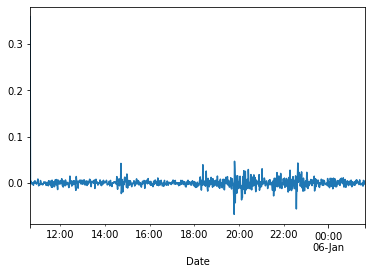

In [17]:
# training the model
results= model.fit()

# plotting residuals
results.resid.plot()

In [18]:
predictions= results.predict(start =train_size, end=train_size+test_size-2,exog=test_X)
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
print(predictions)
for i in range(len(predictions)) : 
  predictions.iloc[i,0]= predictions.iloc[i,0]+predic_garch[i]


                         Pred    Actual
Date                                   
2022-01-06 01:39:00  0.233797  0.234003
2022-01-06 01:40:00  0.232332  0.230943
2022-01-06 01:41:00  0.234853  0.229696
2022-01-06 01:42:00  0.235537  0.232580
2022-01-06 01:43:00  0.240591  0.240977
...                       ...       ...
2022-01-06 03:13:00  0.177390  0.140756
2022-01-06 03:14:00  0.183285  0.144827
2022-01-06 03:15:00  0.182534  0.150349
2022-01-06 03:16:00  0.181087  0.149890
2022-01-06 03:17:00  0.176431  0.137085

[99 rows x 2 columns]


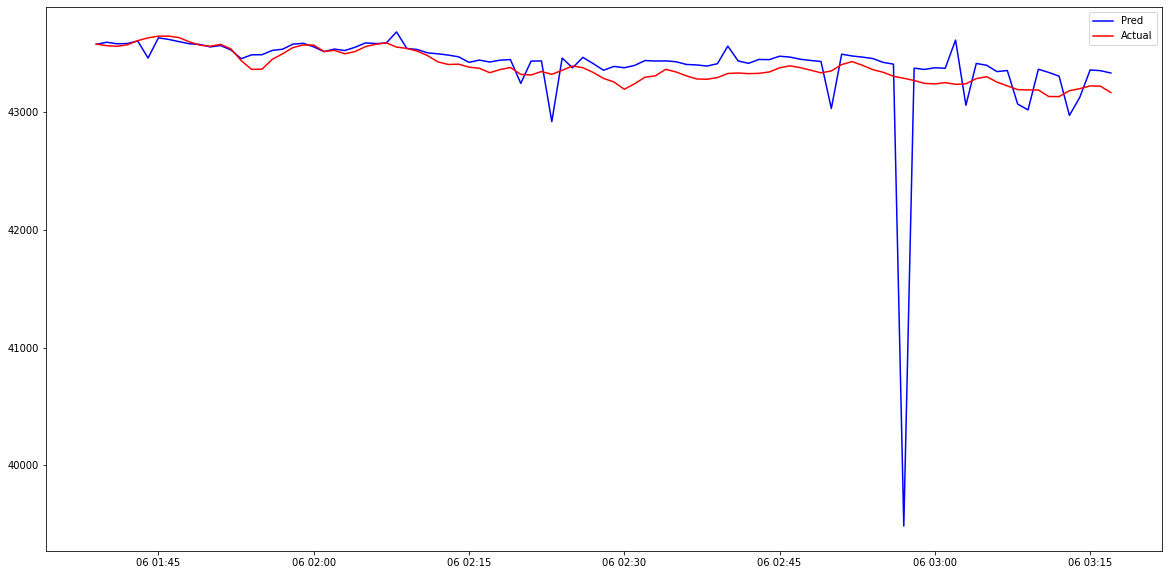

RMSE: [400.00113802]


In [19]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['Actual']])

plt.figure(figsize=(20,10))
plt.plot(predictions.index, trainPredict, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.legend()
plt.show()

from statsmodels.tools.eval_measures import rmse
error=rmse(trainPredict, testPredict)
print("RMSE:",error)